# Download data

In [2]:
import os
import zipfile
import kaggle
# use kaggle api to download the data or manully download the data urself
## ! Kaggle competitions download -c "jane-street-real-time-market-data-forecasting" 

# make the directory to be "data/jane-street-real-time-market-data-forecasting" and extract file there u f the code dont work do it manually
## os.makedirs("data/jane-street-real-time-market-data-forecasting", exist_ok=True) # create directory for jane-street-real-time-market-data-forecasting-housing
## !unzip jane-street-real-time-market-data-forecasting.zip -d data/jane-street-real-time-market-data-forecasting/

# Kaggle Competition 

In [3]:
import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [4]:
# function for import the data .parquet to pandas dataframe
def import_data(i): # the data have 10 partiton 0 to 9
    file_path = f"data/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet"
    df = pd.read_parquet(file_path)
    print(f"import train data part {i}")
    return df

In [5]:
# test/example of the import fuction
# train0 = download_data(0)
train_data = import_data(9) # there are just more data in the train.parquet partition 9

import train data part 9


In [6]:
# import test data 
file_path  = f"data/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet"
test_data = pd.read_parquet(file_path)

In [7]:
# import lag data
file_path  = f"data/jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet"
lag_data = pd.read_parquet(file_path)

# Data Preprocessing

## Data cleaning

In [8]:
# feature selection ## select every feature except 0-4 
all_features_cols = [f"feature_{idx:02d}" for idx in range(79)]

#select target values
target_cols = ["responder_6"]

#select lag values
time_cols = ["date_id","time_id"]

# select the weight values
weight_cols = ["weight"]

## drop the other responder column

# respons to nan values

In [9]:
# remove the nan values
def replace_nan_with_mean_or_zero(column):
    mean_value = column.mean()
    if pd.notnull(mean_value):
        return column.fillna(mean_value)
    else:
        return column.fillna(0)

# try to create the final data with lag from sample

In [11]:
group_by = ["date_id", "symbol_id"]
lag_col = ["responder_6_lag_1"]
result = pd.merge(test_data, lag_data, on = group_by)
X_test = result[all_features_cols + lag_col]
X_test = X_test.apply(replace_nan_with_mean_or_zero)

# Create training data with lag

In [11]:
# Extract features and target, and add lagged target values
# train_data['responder_6_lag_1'] = train_data.groupby(['symbol_id','time_id'])[target_cols].shift(1)
# train_data = train_data.apply(replace_nan_with_mean_or_zero)
# all_features_cols= feature_cols + ['responder_6_lag_1']

In [12]:
# Split the data into training and validation sets
train_data = train_data.apply(replace_nan_with_mean_or_zero)
max_date_id = train_data['date_id'].max()
num_val = 10
train_set = train_data[train_data['date_id'] < max_date_id - num_val]
val_set = train_data[train_data['date_id'] >= max_date_id - num_val]

In [13]:
from sklearn.linear_model import LinearRegression
MLR = LinearRegression()
MLR.fit(train_set[all_features_cols], train_set[target_cols])

LinearRegression()

In [14]:
pred = MLR.predict(val_set[all_features_cols])
r2_score(val_set[target_cols], pred, sample_weight=val_set[weight_cols])

-0.00020766258239746094

In [15]:
pred.max(), pred.min()

(-0.0020954872, -0.011153912)

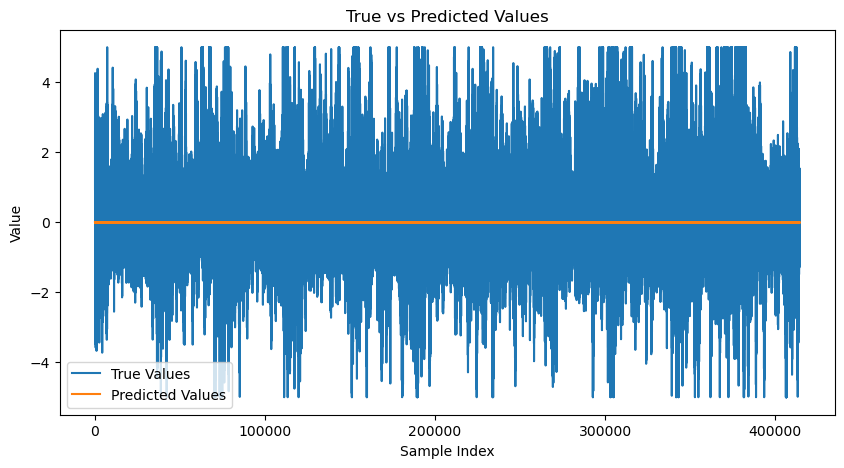

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(val_set[target_cols].reset_index(drop =True), label='True Values')
plt.plot(pred, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [17]:
def validate_5_fold(model, val_set, features, target):
    batch_size = len(val_set)//5
    for i in range(0, len(val_set), batch_size):
        val_batch = val_set.iloc[i:i+batch_size]
        preds = model.predict(val_batch[features])
        score1 = r2_score(val_batch[target_cols], preds ,sample_weight= val_batch[weight_cols])
        print(f'Batch {i//batch_size} r2_score: {score1:.4f}')

In [18]:
validate_5_fold(MLR, val_set, all_features_cols, target_cols)

Batch 0 r2_score: -0.0002
Batch 1 r2_score: -0.0007
Batch 2 r2_score: 0.0000
Batch 3 r2_score: -0.0009
Batch 4 r2_score: 0.0001
Batch 5 r2_score: -6.8764


In [19]:
import joblib
# save
joblib.dump(MLR, "MLR.pkl") 

['MLR.pkl']